<a href="https://colab.research.google.com/github/Deepthi120-ai/Stock-Market-Prediction-/blob/main/D3A_034_102_106_107.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np

import math

import os

import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

from pylab import rcParams
rcParams['figure.figsize'] = 10, 6

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA

#!pip install pmdarima
#from pmdarima.arima import auto_arima

from sklearn.metrics import mean_squared_error, mean_absolute_error

**1. DATA PREPROCESSING AND EDA**

In [3]:
#Importing the data

from datetime import datetime
dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m-%d')
data = pd.read_csv('train.csv',sep=',', index_col=[0], date_parser=lambda x: datetime.strptime(x, "%d-%m-%Y")).fillna(0)
test_data=pd.read_csv('test.csv',sep=',', index_col=[0], date_parser=lambda x: datetime.strptime(x, "%d-%m-%Y"))

# New Section

In [7]:
#dataset(train.csv)

data.head(7)

,Open,High,Low,Volume,Close
Date,,,,,
2015-08-14,57.484790,58.398406,57.342469,171718000,58.237720
2015-08-17,58.274453,59.013611,58.026536,163538800,58.788651
2015-08-18,58.453501,58.917197,58.260678,138242800,58.485638
2015-08-19,58.301997,58.494820,57.650069,193146000,57.801575
2015-08-20,57.374601,57.498558,56.249794,274006400,56.718082
2015-08-21,55.698867,56.373750,53.504350,513102000,53.554852
2015-08-24,48.555217,54.950539,47.237587,648825200,52.342827


In [8]:
#dataset(test.csv)

test_data.head(7)

,Open,High,Low,Volume,Close
Date,,,,,
2021-07-30,293.328006,297.222165,292.788806,70382000,NaN
2021-08-02,297.282094,298.460321,295.065414,62880000,NaN
2021-08-03,296.183715,300.637034,294.925590,64786600,NaN
2021-08-04,299.099384,300.137807,297.122335,56368300,NaN
2021-08-05,298.520228,300.237657,296.902657,46397700,NaN
2021-08-06,297.700012,299.220001,296.260010,54067400,NaN
2021-08-09,297.399994,298.399994,296.040008,48908700,NaN


In [9]:
#details about dataset

data.shape

(1500, 5)

In [10]:
data.describe()

,Open,High,Low,Volume,Close
count,1500.000000,1500.000000,1500.000000,1.500000e+03,1500.000000
mean,117.962567,119.188406,116.766942,1.344507e+08,118.034245
std,69.605960,70.483358,68.640370,6.474265e+07,69.597154
min,46.975433,47.754310,46.728239,4.544800e+07,47.133999
25%,67.216725,67.603262,67.013241,9.138162e+07,67.464885
50%,91.015663,92.208971,90.564149,1.160496e+08,90.918922
75%,142.914154,144.374118,141.944432,1.581502e+08,143.038712
max,303.033493,304.551208,299.958083,6.488252e+08,302.853729


In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1500 entries, 2015-08-14 to 2021-07-29
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    1500 non-null   float64
 1   High    1500 non-null   float64
 2   Low     1500 non-null   float64
 3   Volume  1500 non-null   int64  
 4   Close   1500 non-null   float64
dtypes: float64(4), int64(1)
memory usage: 70.3 KB


In [12]:
#missing values

data.isnull().sum().sum()

0

--> No missing values

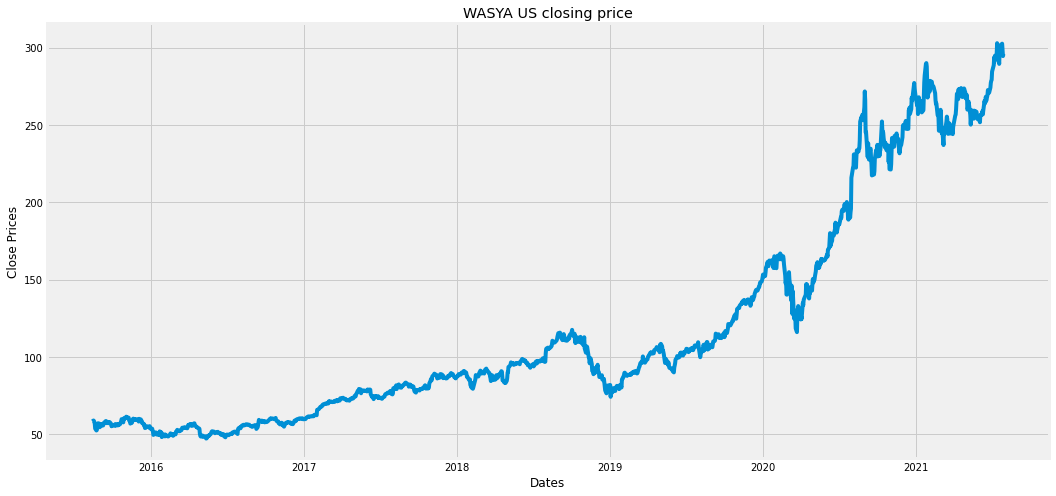

In [13]:
#visualisation

plt.figure(figsize=(16,8))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Close Prices')
plt.plot(data['Close'])
plt.title('WASYA US closing price')
plt.show()

--> Visualize of the per day closing price of the stock

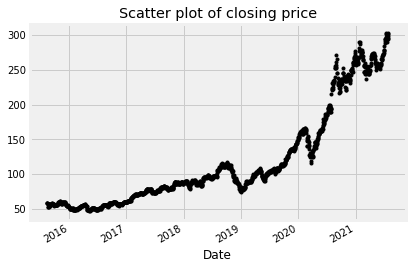

In [14]:
#scatter-plot

df_close=data['Close']
df_close.plot(style='k.')
plt.title('Scatter plot of closing price')
plt.show()

--> similarly, in scatter plot

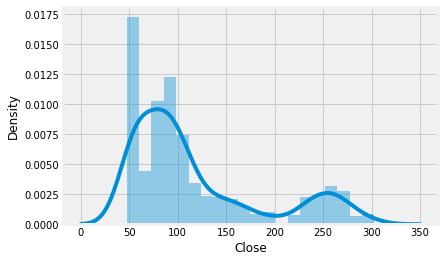

In [15]:
#distribution plots

import seaborn as sns
sns.distplot(data['Close'])

--> and in distribution plot

In [16]:
#checking for outliers

data[(data['Close'] > (data['Close'].mean() + 3*data['Close'].std())) | (data['Close'] < (data['Close'].mean() - 3*data['Close'].std()))].shape

(0, 5)

In [17]:
data[(data['Open'] > (data['Open'].mean() + 3*data['Open'].std())) | (data['Open'] < (data['Open'].mean() - 3*data['Open'].std()))].shape

(0, 5)

In [18]:
data[(data['High'] > (data['High'].mean() + 3*data['High'].std())) | (data['High'] < (data['High'].mean() - 3*data['High'].std()))].shape

(0, 5)

In [19]:
data[(data['Low'] > (data['Low'].mean() + 3*data['Low'].std())) | (data['Low'] < (data['Low'].mean() - 3*data['Low'].std()))].shape

(0, 5)

--> the zeros indicate that there are no outliers 

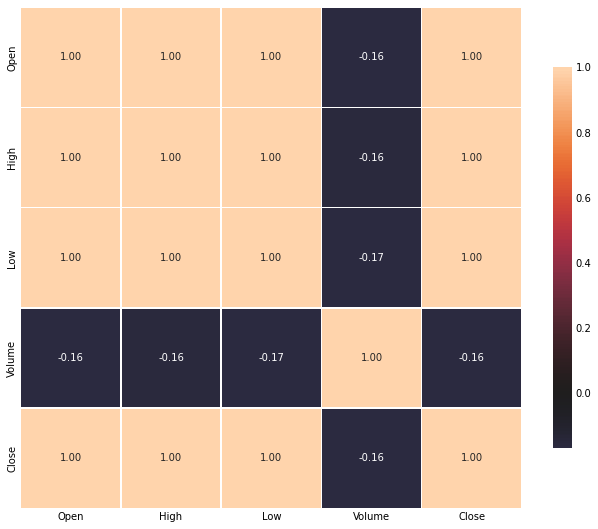

In [20]:
#correlation heat map

def correlation_heatmap(data):
    correlations = data.corr()

    fig, ax = plt.subplots(figsize=(10,10))
    sns.heatmap(correlations, vmax=1.0, center=0, fmt='.2f', square=True, linewidths=.5, annot=True, cbar_kws={"shrink": .70})
    plt.show();
    
correlation_heatmap(data)

Inference:
Open, close, high and low have high positive correlation with each other(perfect +ve correlation). Volume is low negatively correlated with open, close, low and high.

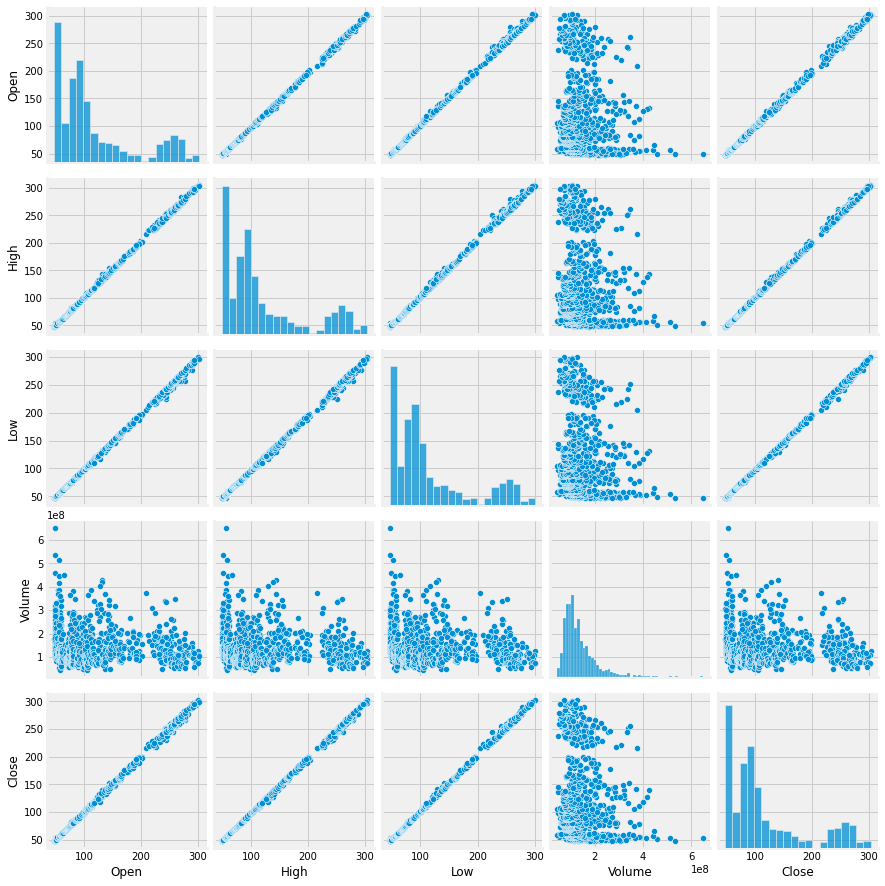

In [21]:
sns.pairplot(data)

**2. REGRESSION MODEL**

In [22]:
#selecting open, high, low and volume as indepedent variabless
X = data.iloc[:,:4]
#selecting close as depdendent variable
y=data.iloc[:,4:]

In [23]:
#k-folds cross-validation (k=3) to assess the performance of our model.
#Code Explanation: model = LinearRegression() creates a linear regression model 
#and the for loop divides the dataset into three folds(by shuffling its indices)
#Inside the loop, we fit the data and then assess its performance by appending 
#its score to a list (scikit-learn returns the R² score which is simply the 
#coefficient of determination).

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold

model = LinearRegression()
scores = []
kfold = KFold(n_splits=3, shuffle=True, random_state=42)
for i, (data, test_data) in enumerate(kfold.split(X, y)):
 model.fit(X.iloc[data,:], y.iloc[data,:])
 scores.append(model.score(X.iloc[test_data,:], y.iloc[test_data,:]))
print(scores)

[0.9997684074453651, 0.9997882135634988, 0.9997960673672119]


--> the scores look really good.

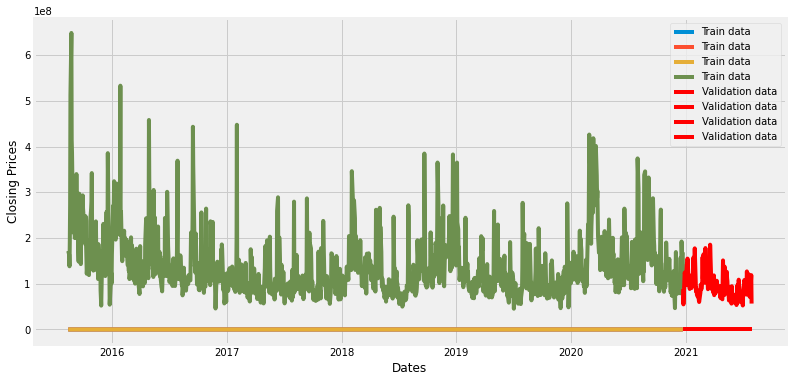

In [24]:
#Multiple regression model

from sklearn.model_selection import train_test_split

x_train,x_test,y_train,y_test = train_test_split(X,y,test_size = 0.1,random_state = 42,shuffle = False)
plt.figure(figsize=(12,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(x_train, label='Train data')
plt.plot(x_test, 'red', label='Validation data')
plt.legend()

In [25]:

from sklearn.metrics import mean_squared_error, mean_absolute_error
#predicting
lr = LinearRegression()
lr.fit(x_train,y_train)
y_pred = lr.predict(x_test)

#assesing the regression model
lr_mse = mean_squared_error(y_test,y_pred)
lr_mae = mean_absolute_error(y_test,y_pred)
lr_rmse = math.sqrt(lr_mse)
lr_accuracy = lr.score(x_test,y_test) * 100

print('Mean Squared Error: {}'.format(lr_mse))
print('Root Mean Squared Error: {}'.format(lr_rmse))
print('Mean absolute Error: {}'.format(lr_mae))
print('Accuracy : {}%\n'.format(lr_accuracy))

Mean Squared Error: 3.083379217664154
Root Mean Squared Error: 1.755955357537359
Mean absolute Error: 1.2992858907975635
Accuracy : 98.62867899365753%



In [26]:
#more information 

import statsmodels.formula.api as smf

x_train['Close'] = y_train
model = smf.ols(formula = 'Close ~ Open + High + Low + Volume',data=x_train)
results = model.fit()
print(results.summary())
print('\n\nCoefficients and Intercepts of a model are: \n{}'.format(results.params))

                            OLS Regression Results                            
Dep. Variable:                  Close   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 1.164e+06
Date:                Sat, 06 Nov 2021   Prob (F-statistic):               0.00
Time:                        16:13:26   Log-Likelihood:                -1726.7
No. Observations:                1350   AIC:                             3463.
Df Residuals:                    1345   BIC:                             3489.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.1474      0.096      1.533      0.1

In [27]:
#r-square and adjusted r-square

from sklearn.metrics import r2_score
from sklearn.metrics import explained_variance_score

r2 = r2_score(y_test, y_pred)

print('The coefficient of determination R-squrae is {}'.format(r2))

Adj_r2 = 1 - (1-r2_score(y_test, y_pred)) * (len(y)-1)/(len(y)-X.shape[1]-1)
print('Adjusted R-squrae is {}'.format(Adj_r2))


print('Variance Score: {}'.format(explained_variance_score(y_test, y_pred)))

The coefficient of determination R-squrae is 0.9862867899365753
Adjusted R-squrae is 0.9862500990735293
Variance Score: 0.9862996216651025


--> this implies that the Regression model predicts with 98.6% correctness

---



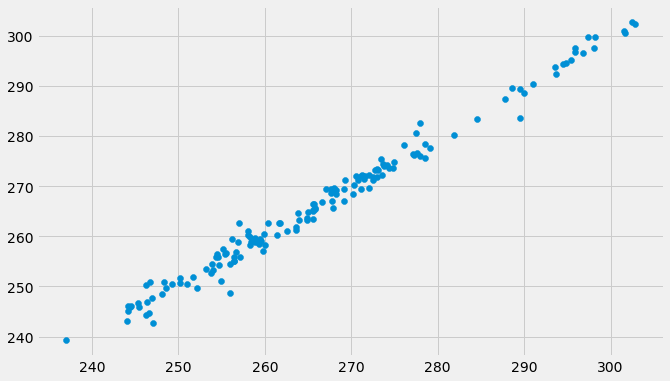

In [ ]:
#above, but in visualisation 

plt.scatter(y_test,y_pred)

**3. Time series model**

Information regarding the ADF (Augmented Dickey-Fuller) Test:
The Dickey-Fuller test is one of the most popular statistical tests. It can be used to determine the presence of unit root in the series, and hence help us understand if the series is stationary or not. The null and alternate hypothesis of this test is:

Null Hypothesis: The series has a unit root (value of a =1)

Alternate Hypothesis: The series has no unit root.

If we fail to reject the null hypothesis, we can say that the series is non-stationary. This means that the series can be linear or difference stationary.

If both mean and standard deviation are flat lines(constant mean and constant variance), the series becomes stationary.

--> First, we need to check if a series is stationary or not because time series analysis only works with stationary data.

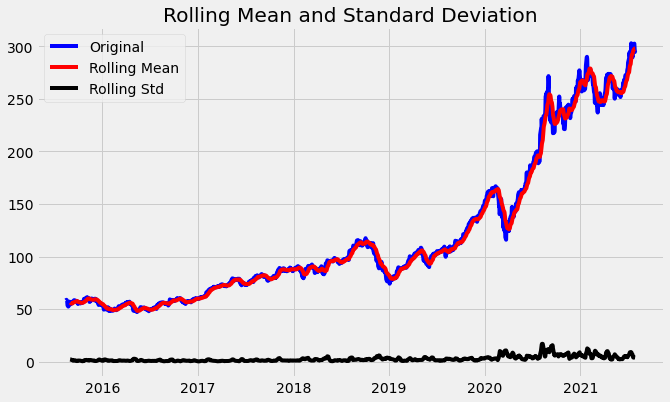

Results of dickey fuller test
Test Statistics                   1.344565
p-value                           0.996847
No. of lags used                 24.000000
Number of observations used    1475.000000
critical value (1%)              -3.434791
critical value (5%)              -2.863501
critical value (10%)             -2.567814
dtype: float64


In [ ]:
#Test for staionarity
def test_stationarity(timeseries):
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()
    #Plot rolling statistics:
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)
    
    print("Results of dickey fuller test")
    adft = adfuller(timeseries,autolag='AIC')
    # output for dft will give us without defining what the values are.
    #hence we manually write what values does it explains using a for loop
    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    for key,values in adft[4].items():
        output['critical value (%s)'%key] =  values
    print(output)
    
test_stationarity(df_close)

--> Through the above graph, we can see the increasing mean and standard deviation and hence our series is not stationary.

the p-value is greater than 0.05 so we cannot reject the Null hypothesis. Also, the test statistics is greater than the critical values. so the data is non-stationary.

In order to perform a time series analysis, we may need to separate seasonality and trend from our series. The resultant series will become stationary through this process.

So let us separate Trend and Seasonality from the time series.

<Figure size 720x432 with 0 Axes>

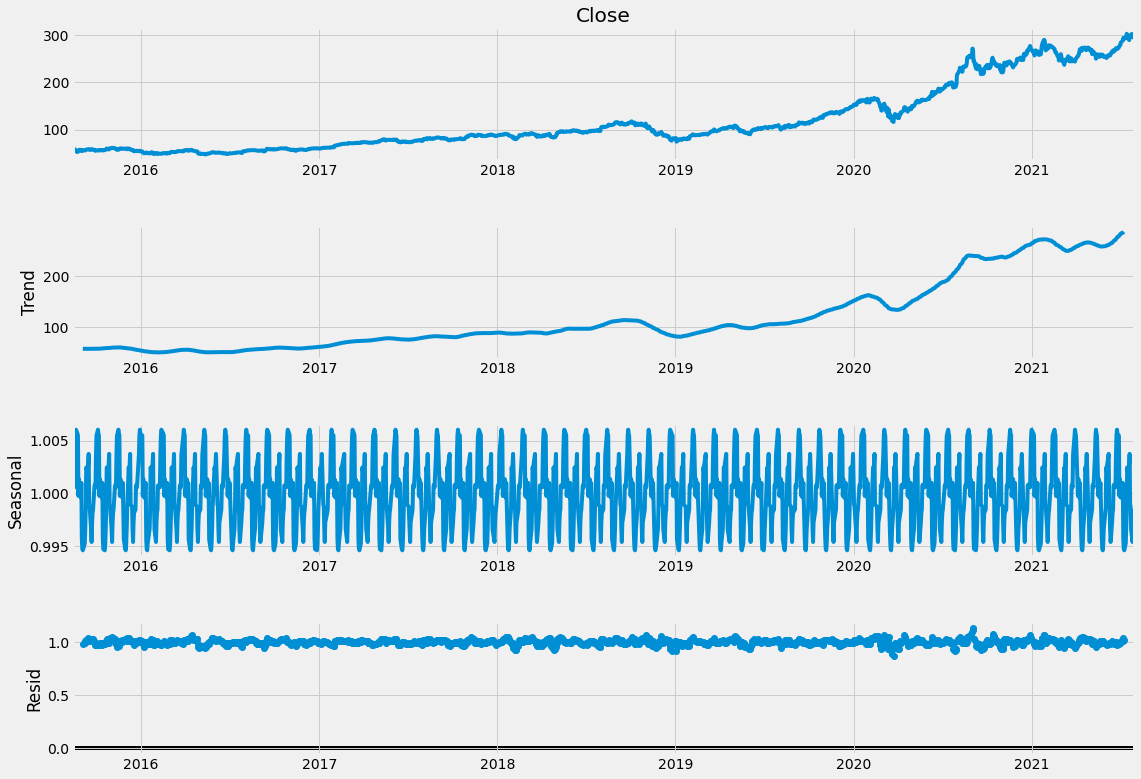

In [ ]:
result = seasonal_decompose(df_close, model='multiplicative', period=30)
fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(17, 12)

Inorder to reduce the magnitude of the values, we start by taking a log of the series and reduce the rising trend in the series. Then after getting the log of the series, we find the rolling average of the series. A rolling average is calculated by taking input for the past 12 months and giving a mean consumption value at every point further ahead in series.

No handles with labels found to put in legend.


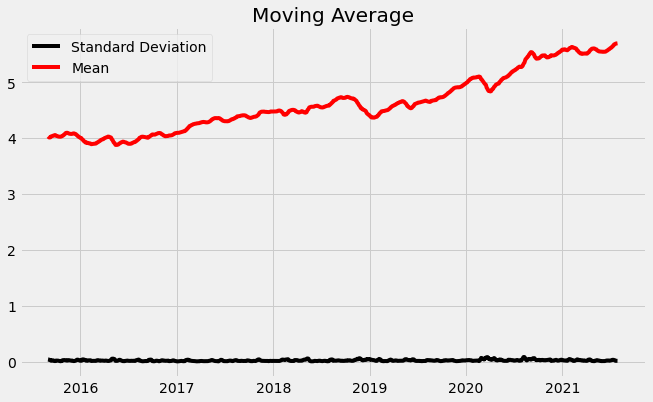

In [ ]:
#df_close =data['Close']
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6
df_log = np.log(df_close)
moving_avg = df_log.rolling(12).mean()
std_dev = df_log.rolling(12).std()
plt.legend(loc='best')
plt.title('Moving Average')
plt.plot(std_dev, color ="black", label = "Standard Deviation")
plt.plot(moving_avg, color="red", label = "Mean")
plt.legend()
plt.show()

--> We are gonna shift sd and mean, to help with our computation

No handles with labels found to put in legend.


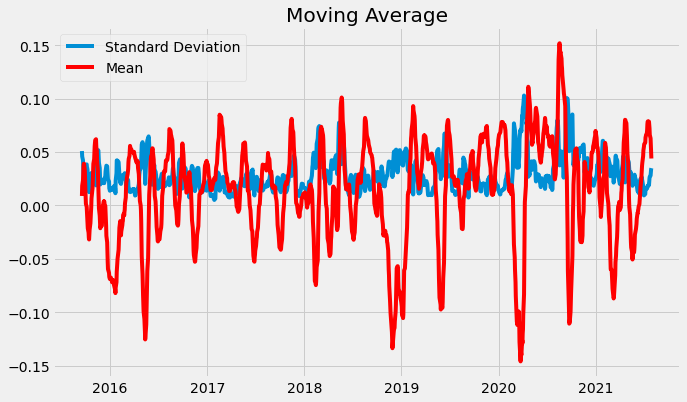

In [ ]:
df_log = df_log - df_log.shift(12)
df_log = df_log.dropna()

moving_avg = df_log.rolling(12).mean()
std_dev = df_log.rolling(12).std()
plt.legend(loc='best')
plt.title('Moving Average')
plt.plot(std_dev, label = "Standard Deviation")
plt.plot(moving_avg, color="red", label = "Mean")
plt.legend()
plt.show()

Now we are going to create an ARIMA model and will train it with the closing price of the stock on the train data. So let us split the data into training and test set and visualize it.

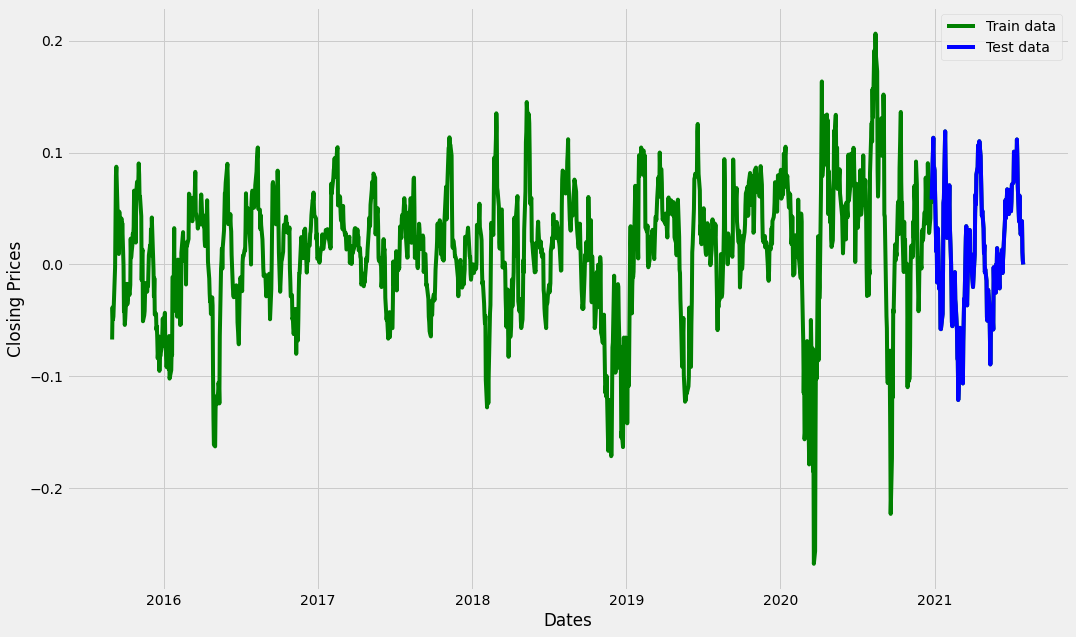

In [ ]:
#split data into train and training set
train_data, test_data = df_log[3:int(len(df_log)*0.9)], df_log[int(len(df_log)*0.9):]
plt.figure(figsize=(16,10))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(df_log, 'green', label='Train data')
plt.plot(test_data, 'blue', label='Test data')
plt.legend()

Its time to choose parameters p,q,d for ARIMA model. We are going to use Auto ARIMA to get the best parameters without even plotting ACF and PACF graphs.

More info on Auto ARIMA: Automatically discover the optimal order for an ARIMA model.
The auto_arima function seeks to identify the most optimal parameters for an ARIMA model, and returns a fitted ARIMA model. This function is based on the commonly-used R function, forecast::auto.arima.
The auro_arima function works by conducting differencing tests (i.e., Kwiatkowski–Phillips–Schmidt–Shin, Augmented Dickey-Fuller or Phillips–Perron) to determine the order of differencing, d, and then fitting models within ranges of defined start_p, max_p, start_q, max_q ranges. If the seasonal optional is enabled, auto_arima also seeks to identify the optimal P and Q hyper- parameters after conducting the Canova-Hansen to determine the optimal order of seasonal differencing, D.

In [ ]:
!pip install pmdarima
from pmdarima.arima import auto_arima

model_autoARIMA = auto_arima(train_data, start_p=0, start_q=0,
                      test='adf',       # use adftest to find             optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
print(model_autoARIMA.summary())

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-3735.346, Time=0.10 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-6147.580, Time=0.08 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-4854.168, Time=0.22 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=-6149.276, Time=0.25 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=-6150.343, Time=0.36 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=-6148.739, Time=0.39 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=inf, Time=0.92 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=-6151.508, Time=0.77 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=-6150.139, Time=0.57 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=-6149.835, Time=0.70 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=-6194.397, Time=1.93 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-6149.789, Time=0.30 sec
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=-6149.710, Time=0.76 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-6148.751, Time=0.30 sec
 ARIMA(1,0,2)(0,0,0)[0] i

So the Auto ARIMA model provided the value of p,d, and q as 3,0 and 0 respectively.

Before moving forward, let’s review the residual plots from auto ARIMA.

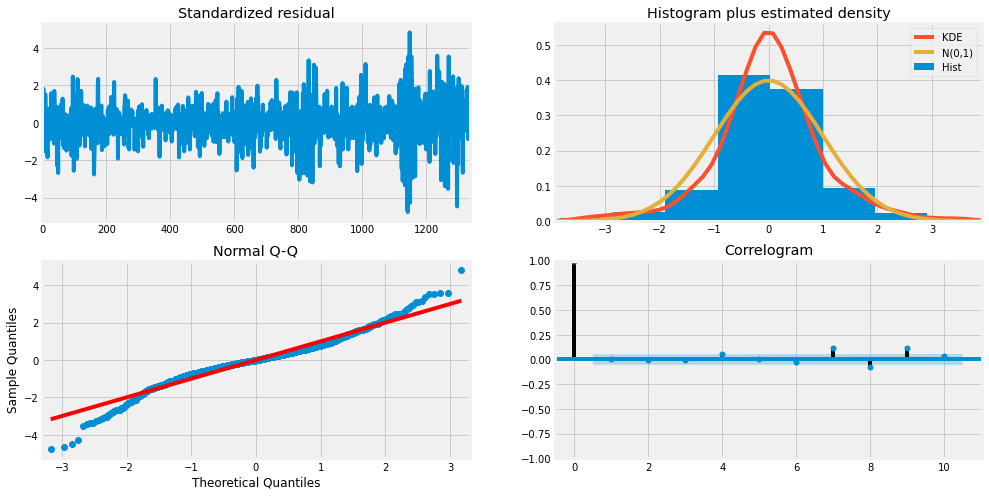

In [ ]:
model_autoARIMA.plot_diagnostics(figsize=(15,8))
plt.show()

Top left: The residual errors seem to fluctuate around a mean of zero and have a uniform variance.

Top Right: The density plot suggest normal distribution with mean zero.

Bottom left: All the dots should fall perfectly in line with the red line. Any significant deviations would imply the distribution is skewed.

Bottom Right: The Correlogram, aka, ACF plot shows the residual errors are not autocorrelated. Any autocorrelation would imply that there is some pattern in the residual errors which are not explained in the model. So you will need to look for more X’s (predictors) to the model.

Overall, it seems to be a good fit. Let’s start forecasting the stock prices.

Next, create an ARIMA model with provided optimal parameters p, d and q.

In [ ]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf
#from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6
#from pmdarima.arima import auto_arima
model = ARIMA(train_data, order=(3,0,0))  
fitted = model.fit()  
print(fitted.summary())

                              ARMA Model Results                              
Dep. Variable:                  Close   No. Observations:                 1336
Model:                     ARMA(3, 0)   Log Likelihood                3073.372
Method:                       css-mle   S.D. of innovations              0.024
Date:                Sat, 06 Nov 2021   AIC                          -6136.745
Time:                        13:50:03   BIC                          -6110.758
Sample:                             0   HQIC                         -6127.007
                                                                              
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.0136      0.007      1.875      0.061      -0.001       0.028
ar.L1.Close     0.8661      0.027     31.670      0.000       0.812       0.920
ar.L2.Close     0.0935      0.036      2.589    

In [ ]:
train_data, testing = df_log[:int(len(df_log)*0.9)], df_log[int(len(df_log)*0.9):]


In [ ]:
fc, se, conf = fitted.forecast(len(testing), alpha=0.05)

since we are getting the valueerror(too many values to unpack), it means our model is overfitting.

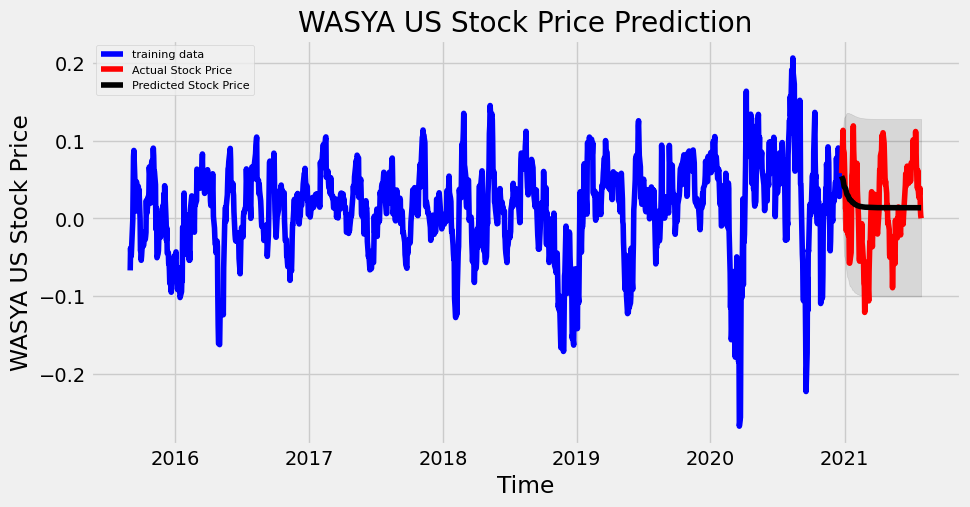

In [ ]:
fc_series = pd.Series(fc, index=test_data.index)
lower_series = pd.Series(conf[:, 0], index=test_data.index)
upper_series = pd.Series(conf[:, 1], index=test_data.index)
# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, color = 'blue' ,label='training data')
plt.plot(test_data, color = 'red', label='Actual Stock Price')
plt.plot(fc_series, color = 'black',label='Predicted Stock Price')
plt.fill_between(lower_series.index, lower_series, upper_series,  color='k', alpha=.10)
plt.title('WASYA US Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('WASYA US Stock Price')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [ ]:
mse = mean_squared_error(testing, fc)
print('MSE: '+str(mse))
mae = mean_absolute_error(testing, fc)
print('MAE: '+str(mae))
rmse = math.sqrt(mean_squared_error(testing, fc))
print('RMSE: '+str(rmse))

MSE: 0.0029100776058043217
MAE: 0.0449126940737829
RMSE: 0.053945135144925924


In [5]:
test = test_data.iloc[:,:4]

In [28]:
from sklearn.linear_model import LinearRegression as LR
linear_regression_model = LR()
linear_regression_model.fit(X,y) # X,y are the independent and dependent variables which are extracted
                                 # from dataframe above
predictions = linear_regression_model.predict(test)

In [30]:
try:
    output = pd.read_csv('submission.csv')
except:
    try:
        output = pd.read_csv('sample_submission.csv')
    except:
        print('Hey Input file issue!!')

output['Close'] = predictions
output.to_csv('submission.csv',index=False)

In [31]:
output

,Date,Close
0,30-07-2021,295.940688
1,02-08-2021,296.422073
2,03-08-2021,298.782819
3,04-08-2021,298.292273
4,05-08-2021,298.558015
5,06-08-2021,297.680718
6,09-08-2021,297.000011
7,10-08-2021,298.129690
8,11-08-2021,297.212379
9,12-08-2021,301.432771
